Data Loading, cleaning and preprocessing

In [1]:
import pandas as pd
import ast
import numpy as np


games_df = pd.read_csv('games.csv')


# Drop 'Unnamed: 0' column, not useful
games_df.drop(columns=['Unnamed: 0'], inplace=True)
# Remove duplicate titles
games_df = games_df.drop_duplicates(subset=['Title'], keep='first')

# reset index after removing duplicates
games_df = games_df.reset_index(drop=True)

# Data type conversion
# Convert list columns from strings to actual lists
games_df['Team'] = games_df['Team'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
games_df['Genres'] = games_df['Genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# convert numerical columns from strings to numeric data types
games_df['Times Listed'] = games_df['Times Listed'].str.replace('K', '000', regex=False).str.replace('.', '', regex=False).astype(int)
games_df['Number of Reviews'] = games_df['Number of Reviews'].str.replace('K', '000', regex=False).str.replace('.', '', regex=False).astype(int)
games_df['Plays'] = games_df['Plays'].str.replace('K', '000', regex=False).str.replace('.', '', regex=False).astype(int)
games_df['Playing'] = games_df['Playing'].str.replace('K', '000', regex=False).str.replace('.', '', regex=False).astype(int)
games_df['Backlogs'] = games_df['Backlogs'].str.replace('K', '000', regex=False).str.replace('.', '', regex=False).astype(int)
games_df['Wishlist'] = games_df['Wishlist'].str.replace('K', '000', regex=False).str.replace('.', '', regex=False).astype(int)

games_df['Rating'] = pd.to_numeric(games_df['Rating'], errors='coerce')


# fill numerical missing values with the mean and drop rows where essential data is missing
games_df.fillna({'Rating': games_df['Rating'].mean()}, inplace=True)
games_df.dropna(subset=['Title', 'Genres'], inplace=True)

# feature Engineering: binary features for each genre
genres = set([genre for sublist in games_df['Genres'] for genre in sublist])
for genre in genres:
    games_df[f'Genre_{genre}'] = games_df['Genres'].apply(lambda x: 1 if genre in x else 0)


games_df.head()


,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,...,Genre_Real Time Strategy,Genre_Turn Based Strategy,Genre_Quiz/Trivia,Genre_Pinball,Genre_Music,Genre_RPG,Genre_Shooter,Genre_Card & Board Game,Genre_Simulator,Genre_Strategy
0,Elden Ring,"Feb 25, 2022","[Bandai Namco Entertainment, FromSoftware]",4.5,39000,39000,"[Adventure, RPG]","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,...,0,0,0,0,0,1,0,0,0,0
1,Hades,"Dec 10, 2019",[Supergiant Games],4.3,29000,29000,"[Adventure, Brawler, Indie, RPG]",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21000,...,0,0,0,0,0,1,0,0,0,0
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","[Nintendo, Nintendo EPD Production Group No. 3]",4.4,43000,43000,"[Adventure, RPG]",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30000,...,0,0,0,0,0,1,0,0,0,0
3,Undertale,"Sep 15, 2015","[tobyfox, 8-4]",4.2,35000,35000,"[Adventure, Indie, RPG, Turn Based Strategy]","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28000,...,0,1,0,0,0,1,0,0,0,0
4,Hollow Knight,"Feb 24, 2017",[Team Cherry],4.4,3000,3000,"[Adventure, Indie, Platform]",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21000,...,0,0,0,0,0,0,0,0,0,0


Initial Data Exploration

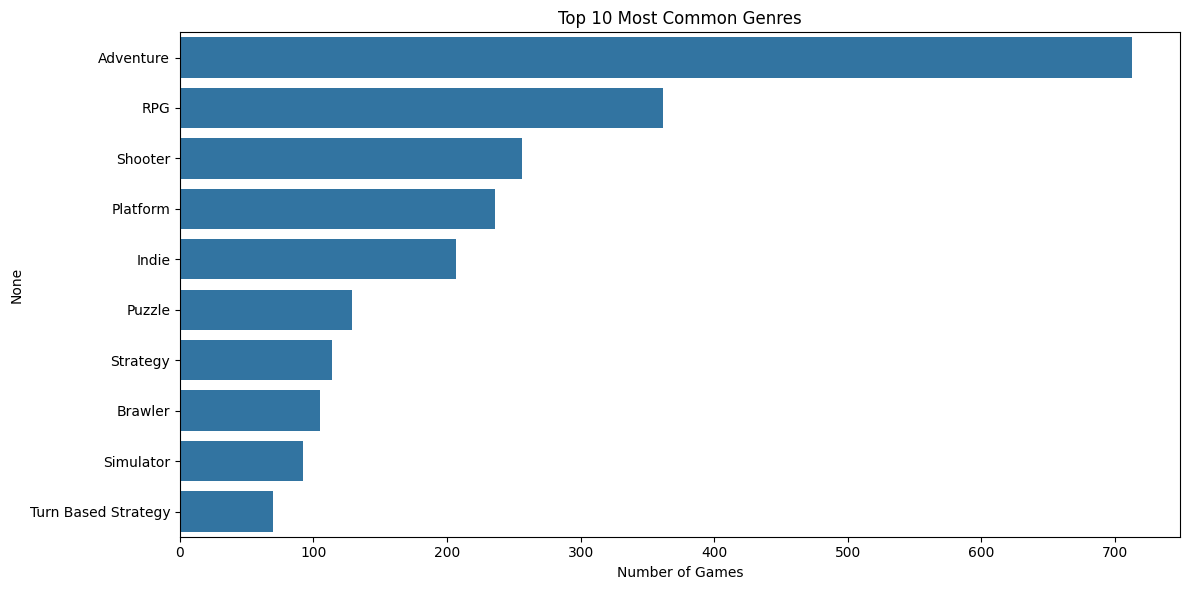


Genre Statistics:
Total number of unique genres: 23

Top 5 genres and their counts:
Adventure    713
RPG          362
Shooter      256
Platform     236
Indie        207
Name: count, dtype: int64


In [3]:
# EDA 1: Genre Distribution
import matplotlib.pyplot as plt
import seaborn as sns


all_genres = []
for genres in games_df['Genres']:
    all_genres.extend(genres)

# see genre frequencies
genre_counts = pd.Series(all_genres).value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values[:10], y=genre_counts.index[:10])
plt.title('Top 10 Most Common Genres')
plt.xlabel('Number of Games')
plt.tight_layout()
plt.show()

print("\nGenre Statistics:")
print(f"Total number of unique genres: {len(genre_counts)}")
print("\nTop 5 genres and their counts:")
print(genre_counts.head())

Rating and Engagement Analysis

In [5]:
# Engagement Score

games_df['Engagement_Score'] = (
    games_df['Times Listed'] + 
    games_df['Number of Reviews'] + 
    games_df['Plays'] + 
    games_df['Playing'] + 
    games_df['Backlogs'] + 
    games_df['Wishlist']
) / 6

# normalizing the score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
games_df['Engagement_Score'] = scaler.fit_transform(games_df[['Engagement_Score']])


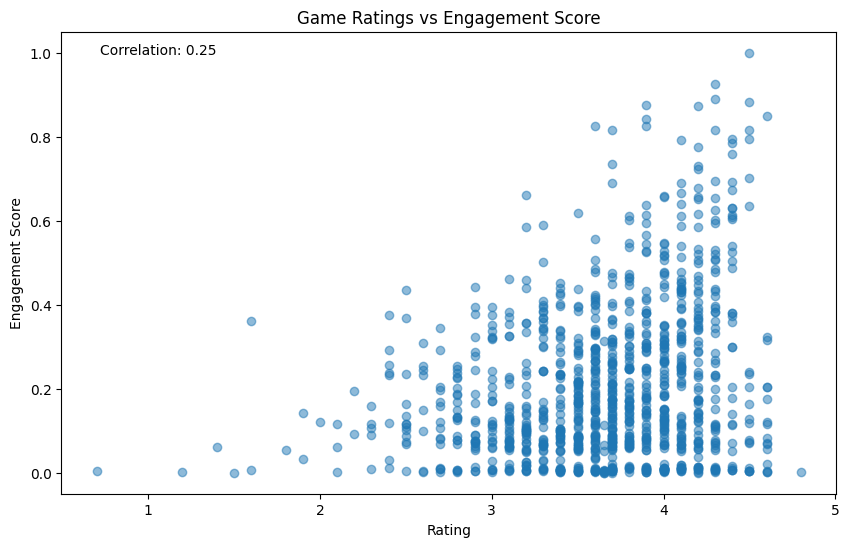


Rating Statistics:
count    1099.000000
mean        3.654696
std         0.536493
min         0.700000
25%         3.400000
50%         3.700000
75%         4.000000
max         4.800000
Name: Rating, dtype: float64

Engagement Score Statistics:
count    1099.000000
mean        0.203562
std         0.183901
min         0.000000
25%         0.069239
50%         0.150003
75%         0.304717
max         1.000000
Name: Engagement_Score, dtype: float64


In [6]:
# EDA 2: Rating vs Engagement
plt.figure(figsize=(10, 6))
plt.scatter(games_df['Rating'], games_df['Engagement_Score'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Engagement Score')
plt.title('Game Ratings vs Engagement Score')

correlation = games_df['Rating'].corr(games_df['Engagement_Score'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes)
plt.show()

# statistics
print("\nRating Statistics:")
print(games_df['Rating'].describe())
print("\nEngagement Score Statistics:")
print(games_df['Engagement_Score'].describe())

Sample of Release Dates:
0    Feb 25, 2022
1    Dec 10, 2019
2    Mar 03, 2017
3    Sep 15, 2015
4    Feb 24, 2017
5    Nov 18, 2011
6    Dec 25, 2020
7    Oct 07, 2021
8    Jun 15, 2018
9    Feb 23, 2017
Name: Release Date, dtype: object

Unique date formats:
['Feb 25, 2022' 'Dec 10, 2019' 'Mar 03, 2017' 'Sep 15, 2015'
 'Feb 24, 2017' 'Nov 18, 2011' 'Dec 25, 2020' 'Oct 07, 2021'
 'Jun 15, 2018' 'Feb 23, 2017']


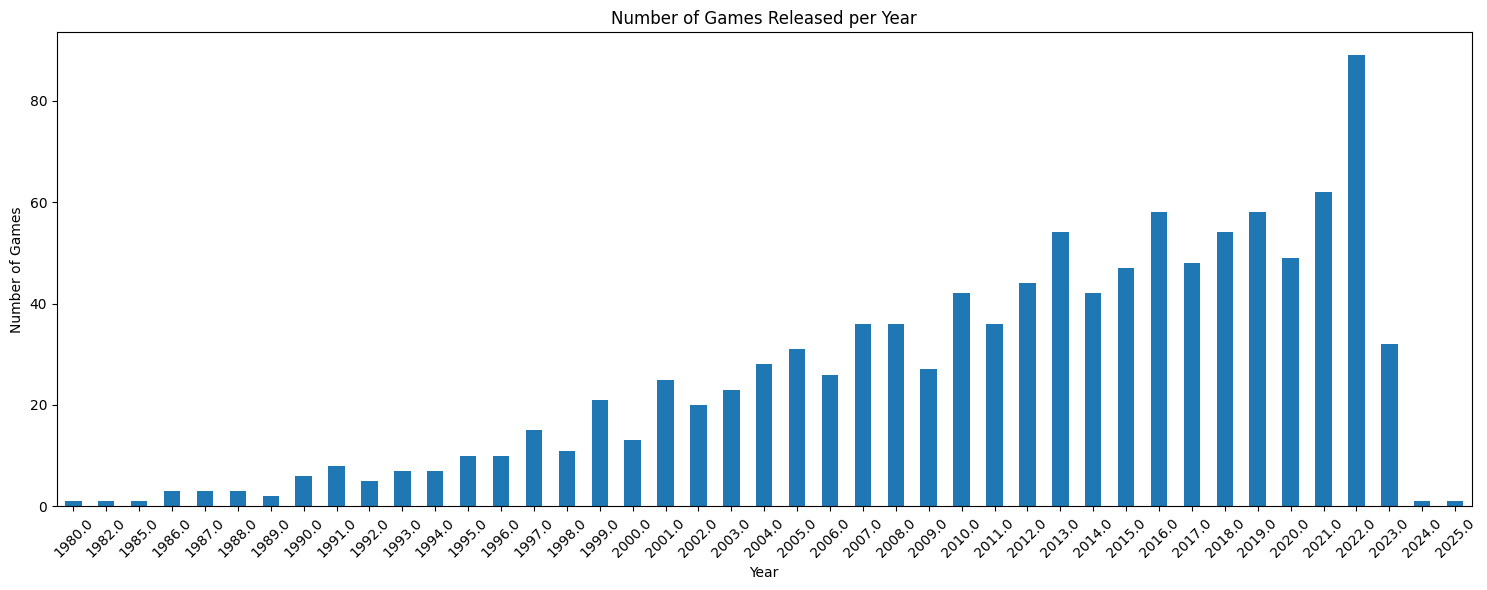


Release Date Statistics:
Number of games with TBD release date: 3
Earliest game: 1980.0
Latest game: 2025.0

Top 5 years by number of releases:
Release Year
2022.0    89
2021.0    62
2019.0    58
2016.0    58
2018.0    54
Name: count, dtype: int64

Release Trends:
Average games per year: 25.488372093023255
Median games per year: 23.0


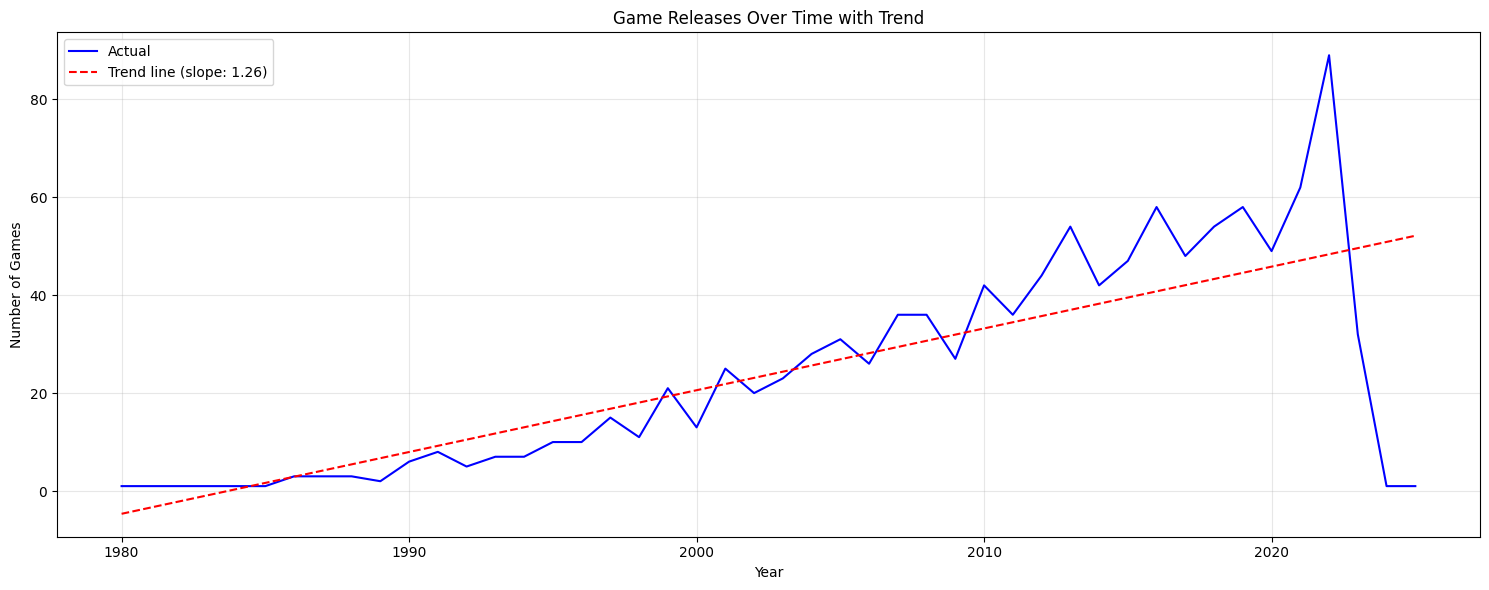

In [8]:
# EDA 3: by Release Year
import datetime

# print logs to find unique date formats
print("Sample of Release Dates:")
print(games_df['Release Date'].head(10))
print("\nUnique date formats:")
print(games_df['Release Date'].unique()[:10])

# switch Release Date to datetime 
games_df['Release Year'] = pd.to_datetime(
    games_df['Release Date'].replace('releases on TBD', pd.NaT), 
    format='%b %d, %Y', 
    errors='coerce'
).dt.year

# Remove NaN 
games_per_year = games_df['Release Year'].dropna().value_counts().sort_index()


plt.figure(figsize=(15, 6))
games_per_year.plot(kind='bar')
plt.title('Number of Games Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# statistics
print("\nRelease Date Statistics:")
print(f"Number of games with TBD release date: {games_df['Release Year'].isna().sum()}")
print(f"Earliest game: {games_per_year.index.min()}")
print(f"Latest game: {games_per_year.index.max()}")
print(f"\nTop 5 years by number of releases:")
print(games_per_year.sort_values(ascending=False).head())

# additional analysis of release trends
print("\nRelease Trends:")
print("Average games per year:", games_per_year.mean())
print("Median games per year:", games_per_year.median())

# trend line
plt.figure(figsize=(15, 6))
years = games_per_year.index.astype(float)
counts = games_per_year.values
z = np.polyfit(years, counts, 1)
p = np.poly1d(z)

plt.plot(years, counts, 'b-', label='Actual')
plt.plot(years, p(years), 'r--', label=f'Trend line (slope: {z[0]:.2f})')
plt.title('Game Releases Over Time with Trend')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Content-Based Recommendations


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# 1: Prepare features
def get_content_similarity():
    # use both genre and numerical features
    feature_cols = [col for col in games_df.columns if col.startswith('Genre_')] + [
        'Rating', 'Times Listed', 'Number of Reviews', 'Plays', 
        'Playing', 'Backlogs', 'Wishlist', 'Engagement_Score'
    ]
    
    # feature matrix
    feature_matrix = games_df[feature_cols]
    

    return cosine_similarity(feature_matrix)

# 2: Content-based recommendation function
def test_content_based_recommendations(game_title, n_recommendations=5):
    # calc content similarity
    content_similarity = get_content_similarity()
    
    try:
        idx = games_df[games_df['Title'] == game_title].index[0]
        content_scores = content_similarity[idx]
        
        # recommendations
        sim_scores = list(enumerate(content_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n_recommendations+1]  # Skip first (self-similarity)
        
        game_indices = [i[0] for i in sim_scores]
        
        # recdataframe
        recommendations = games_df.iloc[game_indices][['Title', 'Genres', 'Rating']]
        recommendations['Content_Similarity'] = [i[1] for i in sim_scores]
        
        return recommendations
    
    except IndexError:
        return "Game not found!"

test_games = ['Elden Ring', 'Minecraft', 'Hollow Knight']
for game in test_games:
    print(f"\nContent-Based Recommendations for '{game}':")
    print(test_content_based_recommendations(game))


Content-Based Recommendations for 'Elden Ring':
                        Title  \
1                       Hades   
17      Red Dead Redemption 2   
14                 Bloodborne   
12                 God of War   
84  Fire Emblem: Three Houses   

                                               Genres  Rating  \
1                    [Adventure, Brawler, Indie, RPG]     4.3   
17                          [Adventure, RPG, Shooter]     4.4   
14                                   [Adventure, RPG]     4.5   
12                          [Adventure, Brawler, RPG]     4.2   
84  [Adventure, RPG, Strategy, Tactical, Turn Base...     4.0   

    Content_Similarity  
1             0.962047  
17            0.947516  
14            0.940775  
12            0.936845  
84            0.931672  

Content-Based Recommendations for 'Minecraft':
                             Title                       Genres  Rating  \
33      Super Smash Bros. Ultimate         [Fighting, Platform]     4.1   
551  Animal C

Collaborative Filtering

In [ ]:
# 1: Create item-based interaction matrix based on engagement metrics
def get_collaborative_similarity():
    # Create engagement matrix using key interaction metrics
    engagement_features = ['Playing', 'Backlogs', 'Wishlist']
    engagement_matrix = games_df[engagement_features].values
    
    # Add review content engagement
    def get_review_engagement(reviews):
        if pd.isna(reviews):
            return 0
        try:
            # Count number of reviews as a proxy for engagement
            return len(ast.literal_eval(reviews))
        except:
            return 0
    
    # calculate review engagement dataframe
    games_df['Review_Engagement'] = games_df['Reviews'].apply(get_review_engagement)
    
    # Normalize review engagement
    scaler = MinMaxScaler()
    games_df['Review_Engagement'] = scaler.fit_transform(
        games_df['Review_Engagement'].values.reshape(-1, 1)
    )
    
    # Add normalized review engagement to matrix
    engagement_matrix = np.column_stack([
        engagement_matrix, 
        games_df['Review_Engagement'].values
    ])
    
    # get similarity between games based on user engagement patterns
    return cosine_similarity(engagement_matrix)

# 2: Collaborative filtering recommendation function
def test_collaborative_recommendations(game_title, n_recommendations=5):
    try:
        # get collab similarity
        collab_similarity = get_collaborative_similarity()
        
        # get game index number
        idx = games_df[games_df['Title'] == game_title].index[0]
        collab_scores = collab_similarity[idx]
        
        # get recommendations
        sim_scores = list(enumerate(collab_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n_recommendations+1]  # Skip first (self-similarity)
        
        game_indices = [i[0] for i in sim_scores]
        
      
        recommendations = games_df.iloc[game_indices][['Title', 'Genres', 'Rating']]
        recommendations['Engagement_Similarity'] = [i[1] for i in sim_scores]
        
        return recommendations
    
    except IndexError:
        return "Game not found!"

# 3: Compare content-based and collaborative filtering results
def compare_recommendations(game_title, n_recommendations=5):
    print(f"\nComparing Different Recommendation Approaches for '{game_title}':")
    
    print("\n1. Content-Based Recommendations:")
    print(test_content_based_recommendations(game_title))
    
    print("\n2. Collaborative Filtering Recommendations:")
    print(test_collaborative_recommendations(game_title))
    
    # overlap between recommendations
    content_recs = test_content_based_recommendations(game_title)
    collab_recs = test_collaborative_recommendations(game_title)
    
    if isinstance(content_recs, pd.DataFrame) and isinstance(collab_recs, pd.DataFrame):
        overlap = set(content_recs['Title']) & set(collab_recs['Title'])
        print(f"\nOverlap between recommendations: {len(overlap)} games")
        if overlap:
            print("Overlapping games:", list(overlap))

test_games = ['Elden Ring', 'Minecraft', 'The Witcher 3: Wild Hunt']
for game in test_games:
    compare_recommendations(game)


Comparing Different Recommendation Approaches for 'Elden Ring':

1. Content-Based Recommendations:
                        Title  \
1                       Hades   
17      Red Dead Redemption 2   
14                 Bloodborne   
12                 God of War   
84  Fire Emblem: Three Houses   

                                               Genres  Rating  \
1                    [Adventure, Brawler, Indie, RPG]     4.3   
17                          [Adventure, RPG, Shooter]     4.4   
14                                   [Adventure, RPG]     4.5   
12                          [Adventure, Brawler, RPG]     4.2   
84  [Adventure, RPG, Strategy, Tactical, Turn Base...     4.0   

    Content_Similarity  
1             0.962047  
17            0.947516  
14            0.940775  
12            0.936845  
84            0.931672  

2. Collaborative Filtering Recommendations:
                             Title                                 Genres  \
487  Hitman World of Assassination    


Analysis for Elden Ring:

Average Ratings:
Content-Based Recommendations: 4.28
Collaborative Recommendations: 3.96

Genre Diversity:
Content-Based Unique Genres: 8
Collaborative Unique Genres: 9

Similarity Scores Distribution:
Content-Based:
count    5.000000
mean     0.943771
std      0.011741
min      0.931672
25%      0.936845
50%      0.940775
75%      0.947516
max      0.962047
Name: Content_Similarity, dtype: float64

Collaborative:
count    5.000000
mean     0.995162
std      0.003682
min      0.990333
25%      0.993435
50%      0.994370
75%      0.998425
max      0.999244
Name: Engagement_Similarity, dtype: float64


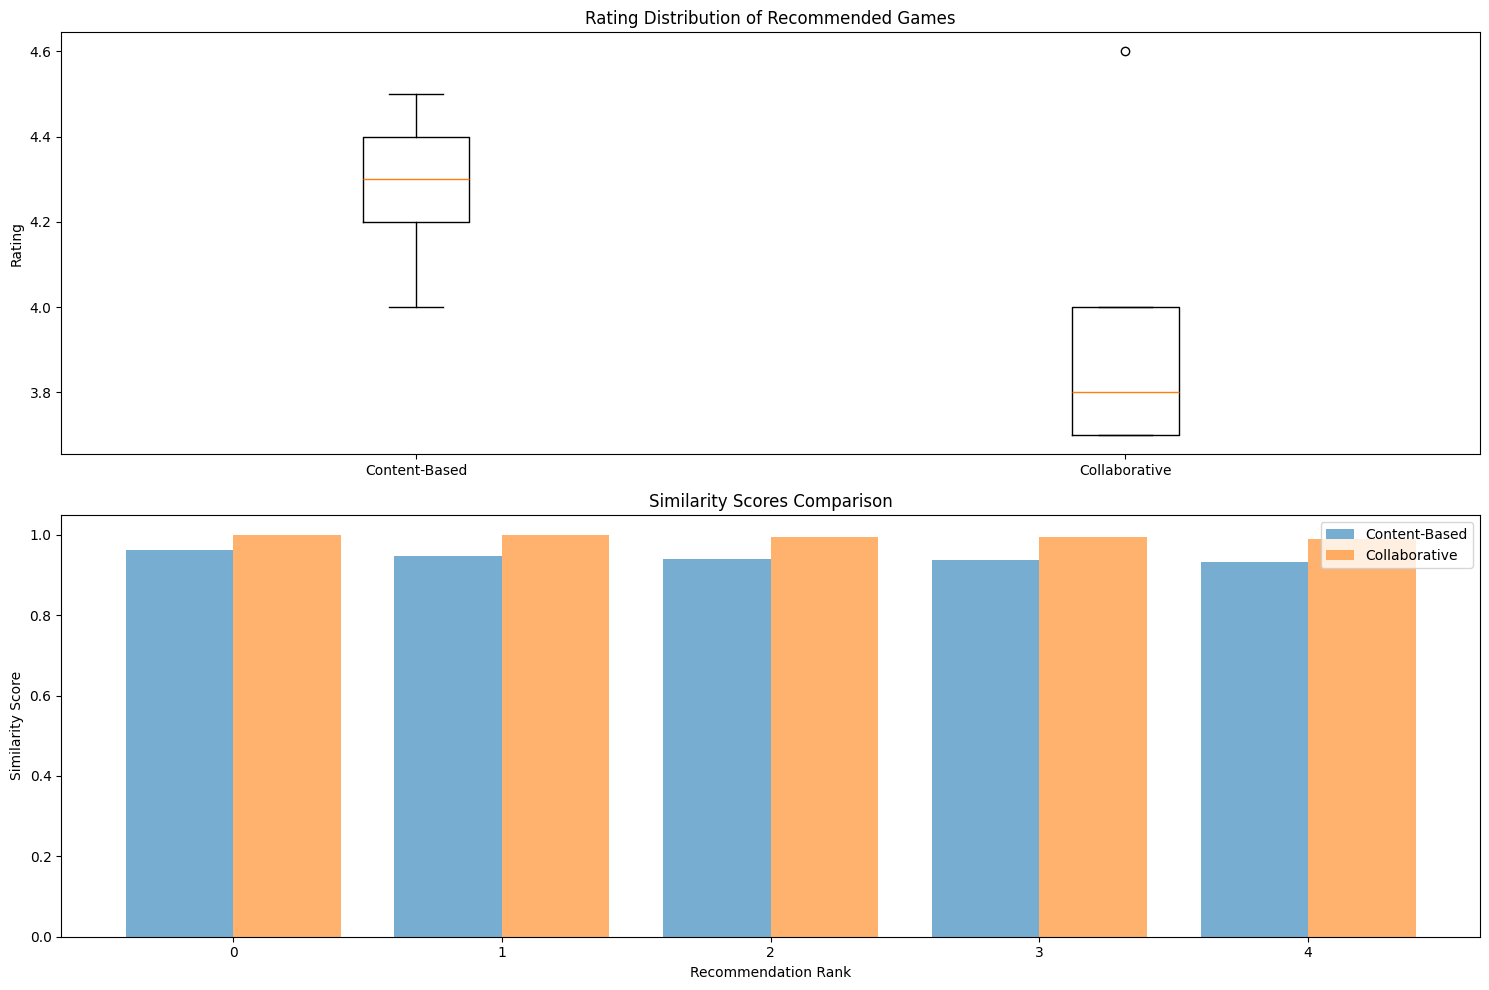


Detailed Recommendation Comparison:

Content-Based Recommendations:
                        Title  \
1                       Hades   
17      Red Dead Redemption 2   
14                 Bloodborne   
12                 God of War   
84  Fire Emblem: Three Houses   

                                               Genres  Rating  \
1                    [Adventure, Brawler, Indie, RPG]     4.3   
17                          [Adventure, RPG, Shooter]     4.4   
14                                   [Adventure, RPG]     4.5   
12                          [Adventure, Brawler, RPG]     4.2   
84  [Adventure, RPG, Strategy, Tactical, Turn Base...     4.0   

    Content_Similarity  
1             0.962047  
17            0.947516  
14            0.940775  
12            0.936845  
84            0.931672  

Collaborative Recommendations:
                             Title                                 Genres  \
487  Hitman World of Assassination         [Adventure, Shooter, Tactical]   
685  

In [17]:
# Analysis of recommendation approaches
def analyze_recommendation_differences(game_title, n_recommendations=5):
    content_recs = test_content_based_recommendations(game_title)
    collab_recs = test_collaborative_recommendations(game_title)
    
    if isinstance(content_recs, pd.DataFrame) and isinstance(collab_recs, pd.DataFrame):
        print(f"\nAnalysis for {game_title}:")
        
        # Average ratings
        print("\nAverage Ratings:")
        print(f"Content-Based Recommendations: {content_recs['Rating'].mean():.2f}")
        print(f"Collaborative Recommendations: {collab_recs['Rating'].mean():.2f}")
        
        # Genre diversity
        content_genres = set([genre for genres in content_recs['Genres'] for genre in genres])
        collab_genres = set([genre for genres in collab_recs['Genres'] for genre in genres])
        
        print("\nGenre Diversity:")
        print(f"Content-Based Unique Genres: {len(content_genres)}")
        print(f"Collaborative Unique Genres: {len(collab_genres)}")
        
        # Similarity scores distribution
        print("\nSimilarity Scores Distribution:")
        print("Content-Based:")
        print(content_recs['Content_Similarity'].describe())
        print("\nCollaborative:")
        print(collab_recs['Engagement_Similarity'].describe())
        
        return {
            'content_genres': content_genres,
            'collab_genres': collab_genres,
            'content_ratings': content_recs['Rating'],
            'collab_ratings': collab_recs['Rating'],
            'content_recs': content_recs,
            'collab_recs': collab_recs
        }

# Test the analysis
test_game = 'Elden Ring'
analysis_results = analyze_recommendation_differences(test_game)

# Visualization
plt.figure(figsize=(15, 10))

# Rating Distribution
plt.subplot(2, 1, 1)
plt.boxplot([analysis_results['content_ratings'], analysis_results['collab_ratings']], 
            labels=['Content-Based', 'Collaborative'])
plt.title('Rating Distribution of Recommended Games')
plt.ylabel('Rating')

# Similarity Scores Comparison
plt.subplot(2, 1, 2)
content_scores = analysis_results['content_recs']['Content_Similarity']
collab_scores = analysis_results['collab_recs']['Engagement_Similarity']

plt.bar(np.arange(len(content_scores)) - 0.2, content_scores, 0.4, label='Content-Based', alpha=0.6)
plt.bar(np.arange(len(collab_scores)) + 0.2, collab_scores, 0.4, label='Collaborative', alpha=0.6)
plt.title('Similarity Scores Comparison')
plt.xlabel('Recommendation Rank')
plt.ylabel('Similarity Score')
plt.legend()

plt.tight_layout()
plt.show()

# detailed comparison
print("\nDetailed Recommendation Comparison:")
print("\nContent-Based Recommendations:")
print(analysis_results['content_recs'][['Title', 'Genres', 'Rating', 'Content_Similarity']])
print("\nCollaborative Recommendations:")
print(analysis_results['collab_recs'][['Title', 'Genres', 'Rating', 'Engagement_Similarity']])

# Genre overlap analysis
content_genres = analysis_results['content_genres']
collab_genres = analysis_results['collab_genres']
overlap_genres = content_genres & collab_genres

print("\nGenre Analysis:")
print(f"Genres only in Content-Based: {sorted(list(content_genres - collab_genres))}")
print(f"Genres only in Collaborative: {sorted(list(collab_genres - content_genres))}")
print(f"Genres in both approaches: {sorted(list(overlap_genres))}")

# Calculate recommendation overlap
content_titles = set(analysis_results['content_recs']['Title'])
collab_titles = set(analysis_results['collab_recs']['Title'])
common_titles = content_titles & collab_titles

print("\nRecommendation Overlap:")
print(f"Number of common recommendations: {len(common_titles)}")
if common_titles:
    print("Common recommendations:", sorted(list(common_titles)))


Comparing Recommendations for 'Elden Ring':

1. Content-Based Recommendations:
                        Title  Rating  Content_Similarity
1                       Hades     4.3            0.962047
17      Red Dead Redemption 2     4.4            0.947516
14                 Bloodborne     4.5            0.940775
12                 God of War     4.2            0.936845
84  Fire Emblem: Three Houses     4.0            0.931672

2. Collaborative Filtering Recommendations:
                             Title  Rating  Engagement_Similarity
487  Hitman World of Assassination     4.6               0.999244
685            PowerWash Simulator     3.7               0.998425
198                Forza Horizon 5     3.8               0.994370
20         Pokémon Legends: Arceus     3.7               0.993435
89             Mario Kart 8 Deluxe     4.0               0.990333

3. Matrix Factorization Recommendations:
                             Title  Rating  MF_Similarity
771           The Beginner's Gu

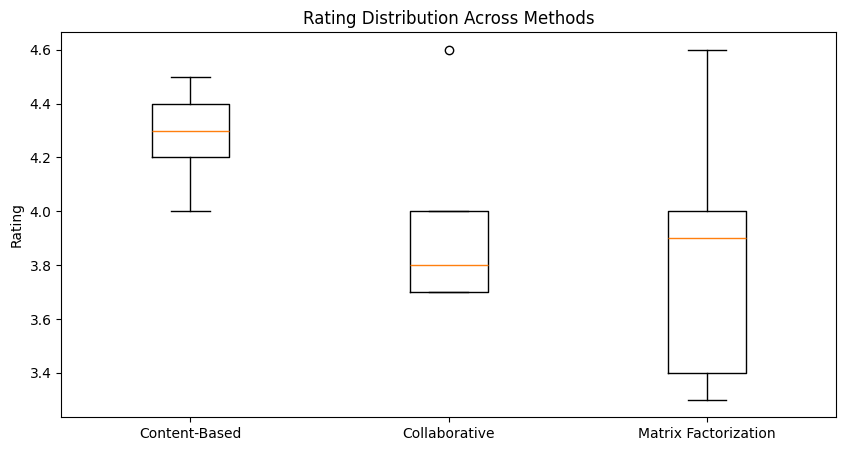


Average Ratings by Method:
Content-Based: 4.28
Collaborative: 3.96
Matrix Factorization: 3.84


In [19]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

def create_interaction_matrix():
    """Create a sparse interaction matrix from engagement metrics"""
    
    # normalize engagement metrics
    engagement_metrics = ['Playing', 'Backlogs', 'Wishlist', 'Times Listed']
    
    # sparse matrix for each metric
    n_games = len(games_df)
    interaction_matrix = np.zeros((n_games, len(engagement_metrics)))
    
    for i, metric in enumerate(engagement_metrics):
        # normalize the metric
        interaction_matrix[:, i] = MinMaxScaler().fit_transform(
            games_df[metric].values.reshape(-1, 1)
        ).ravel()
    
    # convert to sparse matrix
    return csr_matrix(interaction_matrix)

def matrix_factorization_recommendations(game_title, n_recommendations=5):
    """Generate recommendations using matrix factorization"""
    try:
        # built interaction matrix
        interaction_matrix = create_interaction_matrix()
        
        # appropriate number of factors
        max_factors = min(interaction_matrix.shape) - 1
        n_factors = min(20, max_factors)  # Use 20 factors 
        
        # SVD
        U, sigma, Vt = svds(interaction_matrix, k=n_factors)
        
        # convert to diagonal matrix
        sigma = np.diag(sigma)
        
        # reconstruct the matrix
        predicted_interactions = np.dot(np.dot(U, sigma), Vt)
        
        # the game index
        idx = games_df[games_df['Title'] == game_title].index[0]
        
        # similarity scores
        game_interactions = predicted_interactions[idx]
        similar_scores = cosine_similarity(
            predicted_interactions, 
            game_interactions.reshape(1, -1)
        ).flatten()
        
        # top similar games
        similar_games_indices = similar_scores.argsort()[::-1][1:n_recommendations+1]
        
        # recommendations dataframe
        recommendations = games_df.iloc[similar_games_indices][
            ['Title', 'Genres', 'Rating']
        ].copy()
        recommendations['MF_Similarity'] = similar_scores[similar_games_indices]
        
        return recommendations
    
    except IndexError:
        return "Game not found!"

# Compare different recommendation methods
def compare_recommendations(game_title, n_recommendations=5):
    """Compare different recommendation methods"""
    print(f"\nComparing Recommendations for '{game_title}':")
    
    # Get recommendations from each method
    content_recs = test_content_based_recommendations(game_title)
    collab_recs = test_collaborative_recommendations(game_title)
    mf_recs = matrix_factorization_recommendations(game_title)
    
    if isinstance(content_recs, pd.DataFrame):
        # Print recommendations from each method
        print("\n1. Content-Based Recommendations:")
        print(content_recs[['Title', 'Rating', 'Content_Similarity']])
        
        print("\n2. Collaborative Filtering Recommendations:")
        print(collab_recs[['Title', 'Rating', 'Engagement_Similarity']])
        
        print("\n3. Matrix Factorization Recommendations:")
        print(mf_recs[['Title', 'Rating', 'MF_Similarity']])
        
        # Calculate overlap
        content_titles = set(content_recs['Title'])
        collab_titles = set(collab_recs['Title'])
        mf_titles = set(mf_recs['Title'])
        
        all_common = content_titles & collab_titles & mf_titles
        
        print("\nRecommendation Overlap Analysis:")
        print(f"Games recommended by all methods: {len(all_common)}")
        if all_common:
            print("Common recommendations:", sorted(list(all_common)))
        
        # Visualize ratings distribution
        plt.figure(figsize=(10, 5))
        data = [
            content_recs['Rating'],
            collab_recs['Rating'],
            mf_recs['Rating']
        ]
        plt.boxplot(data, labels=['Content-Based', 'Collaborative', 'Matrix Factorization'])
        plt.title('Rating Distribution Across Methods')
        plt.ylabel('Rating')
        plt.show()
        
        return {
            'content': content_recs,
            'collaborative': collab_recs,
            'matrix_factorization': mf_recs
        }
    
    return None

# Test the system
test_game = 'Elden Ring'
results = compare_recommendations(test_game)

# Print additional statistics
if results:
    print("\nAverage Ratings by Method:")
    print(f"Content-Based: {results['content']['Rating'].mean():.2f}")
    print(f"Collaborative: {results['collaborative']['Rating'].mean():.2f}")
    print(f"Matrix Factorization: {results['matrix_factorization']['Rating'].mean():.2f}")

Hybrid Recommendations


Comparing Hybrid Recommendation Strategies for 'Elden Ring':

Safe Strategy:
                                               Title  Rating     Score
Hades                                          Hades     4.3  0.577228
Red Dead Redemption 2          Red Dead Redemption 2     4.4  0.568510
Bloodborne                                Bloodborne     4.5  0.564465
God of War                                God of War     4.2  0.562107
Fire Emblem: Three Houses  Fire Emblem: Three Houses     4.0  0.559003

Balanced Strategy:
                                                       Title  Rating     Score
Hitman World of Assassination  Hitman World of Assassination     4.6  0.599546
Hades                                                  Hades     4.3  0.384819
Red Dead Redemption 2                  Red Dead Redemption 2     4.4  0.379006
Bloodborne                                        Bloodborne     4.5  0.376310
God of War                                        God of War     4.2  0.374738

E

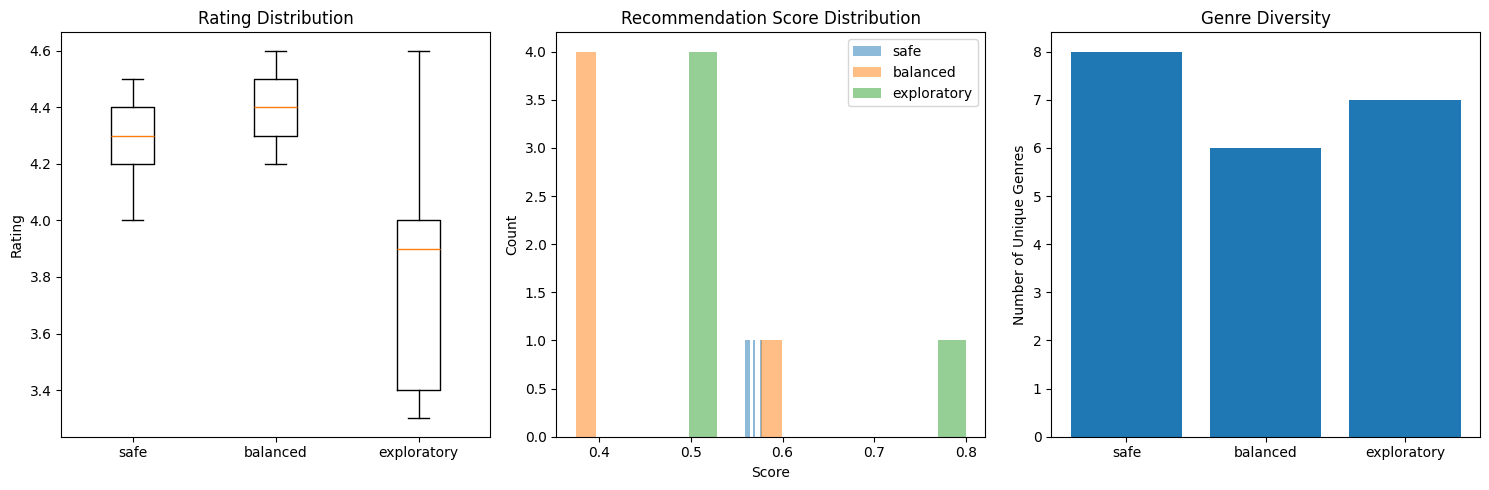


Detailed Strategy Analysis:

Safe Strategy Statistics:
Average Rating: 4.28
Average Score: 0.57
Rating Range: 4.00 - 4.50

Balanced Strategy Statistics:
Average Rating: 4.40
Average Score: 0.42
Rating Range: 4.20 - 4.60

Exploratory Strategy Statistics:
Average Rating: 3.84
Average Score: 0.56
Rating Range: 3.30 - 4.60


In [21]:
def get_hybrid_recommendations(game_title, 
                             diversity_preference='balanced',
                             n_recommendations=5):
    """
    Get hybrid recommendations with adjustable diversity preference
    
    Key Parameters:
    -----------
    game_title
        
    diversity_preference
        'safe': Favors similar, highly-rated games
        'balanced': Equal weight to different approaches
        'exploratory': Favors diverse recommendations
   
        
    """
    
    # weights for different strategies
    weights = {
        'safe': {'content': 0.6, 'collab': 0.3, 'mf': 0.1},
        'balanced': {'content': 0.4, 'collab': 0.3, 'mf': 0.3},
        'exploratory': {'content': 0.2, 'collab': 0.3, 'mf': 0.5}
    }
    
    try:
        # recommendations from each method
        content_recs = test_content_based_recommendations(game_title)
        collab_recs = test_collaborative_recommendations(game_title)
        mf_recs = matrix_factorization_recommendations(game_title)
        
        if isinstance(content_recs, str):  # Error checking
            return f"Game '{game_title}' not found!"
        
        # dictionary to store all recommended games with their scores
        all_games = {}
        w = weights[diversity_preference]
        
        # add scores from different methods
        for idx, row in content_recs.iterrows():
            game = row['Title']
            all_games[game] = {
                'Rating': row['Rating'],
                'Genres': row['Genres'],
                'Score': w['content'] * row['Content_Similarity']
            }
            
        for idx, row in collab_recs.iterrows():
            game = row['Title']
            if game in all_games:
                all_games[game]['Score'] += w['collab'] * row['Engagement_Similarity']
            else:
                all_games[game] = {
                    'Rating': row['Rating'],
                    'Genres': row['Genres'],
                    'Score': w['collab'] * row['Engagement_Similarity']
                }
                
        for idx, row in mf_recs.iterrows():
            game = row['Title']
            if game in all_games:
                all_games[game]['Score'] += w['mf'] * row['MF_Similarity']
            else:
                all_games[game] = {
                    'Rating': row['Rating'],
                    'Genres': row['Genres'],
                    'Score': w['mf'] * row['MF_Similarity']
                }
        
        # convert to DataFrame and sort by score
        hybrid_df = pd.DataFrame.from_dict(all_games, orient='index')
        hybrid_df['Title'] = hybrid_df.index
        hybrid_df = hybrid_df.sort_values('Score', ascending=False)
        
        # top 5 recommendations
        return hybrid_df.head(n_recommendations)
    
    except Exception as e:
        return f"Error generating recommendations: {str(e)}"

# compare hybrid recommendations with different strategies
def compare_hybrid_strategies(game_title, n_recommendations=5):
    """Compare different hybrid recommendation strategies"""
    
    strategies = ['safe', 'balanced', 'exploratory']
    results = {}
    
    print(f"\nComparing Hybrid Recommendation Strategies for '{game_title}':")
    
    for strategy in strategies:
        print(f"\n{strategy.capitalize()} Strategy:")
        recs = get_hybrid_recommendations(game_title, strategy, n_recommendations)
        results[strategy] = recs
        print(recs[['Title', 'Rating', 'Score']])
    
    # analyze diversity
    print("\nDiversity Analysis:")
    for strategy in strategies:
        unique_genres = set()
        for genres in results[strategy]['Genres']:
            unique_genres.update(genres)
        print(f"{strategy.capitalize()} strategy unique genres: {len(unique_genres)}")
    
    
    plt.figure(figsize=(15, 5))
    
    # rating Distribution
    plt.subplot(1, 3, 1)
    data = [results[s]['Rating'] for s in strategies]
    plt.boxplot(data, labels=strategies)
    plt.title('Rating Distribution')
    plt.ylabel('Rating')
    
    # score Distribution
    plt.subplot(1, 3, 2)
    for strategy in strategies:
        plt.hist(results[strategy]['Score'], alpha=0.5, label=strategy)
    plt.title('Recommendation Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.legend()
    
    # genre Diversity
    plt.subplot(1, 3, 3)
    genre_counts = []
    for strategy in strategies:
        unique_genres = set()
        for genres in results[strategy]['Genres']:
            unique_genres.update(genres)
        genre_counts.append(len(unique_genres))
    
    plt.bar(strategies, genre_counts)
    plt.title('Genre Diversity')
    plt.ylabel('Number of Unique Genres')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Test the hybrid system
test_game = 'Elden Ring'
hybrid_results = compare_hybrid_strategies(test_game)

print("\nDetailed Strategy Analysis:")
for strategy, recs in hybrid_results.items():
    print(f"\n{strategy.capitalize()} Strategy Statistics:")
    print(f"Average Rating: {recs['Rating'].mean():.2f}")
    print(f"Average Score: {recs['Score'].mean():.2f}")
    print(f"Rating Range: {recs['Rating'].min():.2f} - {recs['Rating'].max():.2f}")

For future works

In [24]:


def get_diverse_recommendations(game_title, n_recommendations=5, content_weight=0.7, diversity_threshold=0.3):
    try:
        recommendations = []
        idx = games_df[games_df['Title'] == game_title].index[0]
        
        content_similarity = get_content_similarity()
        content_scores = content_similarity[idx]
        
        collab_similarity = get_collaborative_similarity()
        collab_scores = collab_similarity[idx]
        
   
        hybrid_scores = (content_weight * content_scores) + ((1 - content_weight) * collab_scores)
        
        
        sorted_indices = np.argsort(hybrid_scores)[::-1]
        sorted_indices = sorted_indices[sorted_indices != idx]
        
        # Add first recommendation
        recommendations.append(sorted_indices[0])
        
        # Add diverse recommendations
        for i in sorted_indices[1:]:
      
            max_similarity = max([content_similarity[i][j] for j in recommendations])
            if max_similarity < diversity_threshold:
                recommendations.append(i)
                if len(recommendations) == n_recommendations:
                    break
        recommended_games['Similarity_Score'] = hybrid_scores[recommendations]
        
        return recommended_games[['Title', 'Genres', 'Rating', 'Similarity_Score']]
        
    except IndexError:
        return "Game not found! Please check the spelling."
    





IndentationError: unindent does not match any outer indentation level (<string>, line 31)